In [257]:
from typing import TypedDict, Annotated, Optional # Using for defining the state of our agent graph
from langgraph.graph import add_messages, StateGraph, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import initialize_agent, tool, AgentType
# from langchain_openai import ChatOpenAI
from langchain.tools import Tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
from dotenv import load_dotenv
import datetime
import json

load_dotenv()

# LangChain-compatible Gemini model
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0.7)

In [258]:
from pydantic import BaseModel

def search_web(query: str):
    search_results = TavilySearchResults(max_results=2).invoke({"query": query})

    if not search_results:
        return "No relevant search results found."

    return search_results

class SearchToolSchema(BaseModel):
    query: str

# search_tool = Tool.from_function(
#     func=search_web,
#     name="tavily_Search",
#     description="Retrieve real-time information like weather, news, or current events using web search.",
#     args_schema= SearchToolSchema
# ) # Find only given number of result
@tool
def get_system_time(format: str = "%Y-%m-%d %H:%M:%S"):
    """Returns the current date and time in the specific format"""
    current_time = datetime.datetime.now()
    formatted_time = current_time.strftime(format)
    return formatted_time

from langchain.tools import tool

@tool
def calculate_days_between(input: str) -> int:
    """Calculate the number of days between two dates in 'YYYY-MM-DD to YYYY-MM-DD' format."""
    from datetime import datetime
    try:
        # Clean and split
        parts = input.strip().replace('"', '').replace("'", "").split(" to ")
        if len(parts) != 2:
            return "Input must be in format: 'YYYY-MM-DD to YYYY-MM-DD'"
        
        start_date = parts[0].strip()
        end_date = parts[1].strip()

        fmt = "%Y-%m-%d"
        delta = datetime.strptime(end_date, fmt) - datetime.strptime(start_date, fmt)
        return delta.days

    except Exception as e:
        return f"Error parsing input: {e}"

search_tool = TavilySearchResults(search_depth='basic') # Find only given number of result

tools = [search_tool, get_system_time, calculate_days_between] # storing search tool in general tool array

memory = MemorySaver()

In [259]:
# llm_with_tools = llm.bind_tools(tools=tools)
# llm_with_tools = initialize_agent(tools=tools, llm=llm, agent="zero-shot-react-description", verbose=True)
llm_with_tools = initialize_agent(tools=tools, llm=llm, agent="zero-shot-react-description", verbose=True)
# llm_with_tools = initialize_agent(tools=tools, llm=llm, agent=AgentType.OPENAI_FUNCTIONS, verbose=True)
# response = llm_with_tools.invoke("What's the todays weather of Gwalior India")
# response

In [260]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return{
        "messages": state["messages"] + [AIMessage(content=result["output"])]
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else:
        return "end"
    
async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""
    # Get the tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls

    # Initialize list to store tool messages
    tool_messages = []

    # Process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
        
        # Handle the search tool
        if tool_name == search_tool.name:
            # Execute the search tool with the provided arguments
            search_results = await search_tool.ainvoke(tool_args)

            # Create a ToolMessage for this result
            tool_message = ToolMessage(
                content = str(search_results),
                tool_call_id=tool_id,
                name = tool_name
            )

            tool_messages.append(tool_message)

    # Add the tool messages to the state
    return {
        "messages": tool_messages
    }

graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_edge("tool_node", "model")
graph_builder.add_conditional_edges("model", tools_router, {"tool_node": "tool_node", "end": END})

graph = graph_builder.compile(checkpointer=memory)

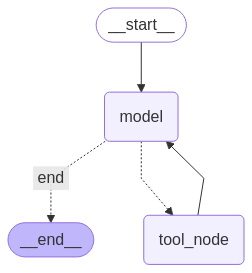

In [261]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
# config = {
#     "configurable":{
#         "thread_id": 123
#     }
# }

# response = await graph.ainvoke({
#     "messages": [HumanMessage(content="When is the last spaceX launch and how many days have passed from today?")]
# }, config=config)

# response

In [263]:
config = {
    "configurable":{
        "thread_id": 127
    }
}

events = graph.astream_events({
    "messages": [HumanMessage(content="Hi, I'm Irshad")]
}, config=config, version="v2")

async for event in graph.astream_events({
    "messages": [HumanMessage(content="Gice me 150 words poem for kids")]
}, config=config, version="v2"):
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)



> Entering new AgentExecutor chain...
Thought:I need to generate a 150-word poem for kids.  I don't need external tools for this.

Thought: I will write a poem about a playful puppy.

Final Answer:

A fluffy pup, so small and round,
With wagging tail, he bounds around.
He chases squirrels up trees so high,
And barks a greeting to the sky.

He rolls in grass, a happy sight,
His fur all green, a playful fright.
He digs and digs with joyful glee,
A tiny hole for you and me.

He chews on toys, both big and small,
A playful pup, he's loved by all.
He licks your face, a wet, warm kiss,
A furry friend, you can't dismiss.

He sleeps all snug, a furry ball,
And dreams of squirrels, both big and small.
He wakes and yawns, a sleepy sigh,
Ready for fun, beneath the sky.

His playful heart, so full of cheer,
Brings joy and laughter, far and near.
A puppy's love, a gift so true,
A happy friend, for me and you.
Thought:I need to generate a 150-word poem for kids.  I don't need external tools for th